# Diabetes Prediction using ML Algorithms

In [13]:
# import all libraries here
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import boto3
from io import BytesIO
from collections import Counter

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from imblearn.over_sampling import SMOTE
import pickle

## Upload the dataset files to local directory of Sagemaker Studio and read it in a pandas dataframe

In [8]:
# Read data into pandas dataframe
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
#print first five records
#df.head()

#print last five records
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


## Exploratory Data Analysis
Perform some Exploratory Data Analysis in the diabetes dataset

In [10]:
# Check the overall statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [11]:
# Print the number of records and variables in the data
samples, vars = df.shape
print('Number Of Samples: ', samples)
print('Number Of Variables: ', vars)

Number Of Samples:  768
Number Of Variables:  9


There are total 768 samples, 8 features and a target variable showing that whether a record is associated with diabetes or not.

In [12]:
#Get the overall info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
# Initialize lists to store information about each variable
variable_names = []
data_types = []
num_unique_values = []
num_null_values = []

# Iterate through each column in the DataFrame
for column in df.columns:
    variable_names.append(column)
    data_types.append(df[column].dtype)
    num_unique_values.append(df[column].nunique())
    num_null_values.append(df[column].isnull().sum())

# Create the DataFrame with the collected information
variable_info_df = pd.DataFrame({
    'Variable': variable_names,
    'Data Type': data_types,
    'Number of Unique Values': num_unique_values,
    'Number of Null Values': num_null_values
})
variable_info_df

,Variable,Data Type,Number of Unique Values,Number of Null Values
0,Pregnancies,int64,17,0
1,Glucose,int64,136,0
2,BloodPressure,int64,47,0
3,SkinThickness,int64,51,0
4,Insulin,int64,186,0
5,BMI,float64,248,0
6,DiabetesPedigreeFunction,float64,517,0
7,Age,int64,52,0
8,Outcome,int64,2,0


From the table above, we can see that there are no missing values present in our dataset.

In [18]:
# Check the number of duplicated records
df.duplicated().sum()

0

The diabetes dataset has total 3854 duplicate records. We are now going to remove these duplicates.

In [19]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Correlation Plot

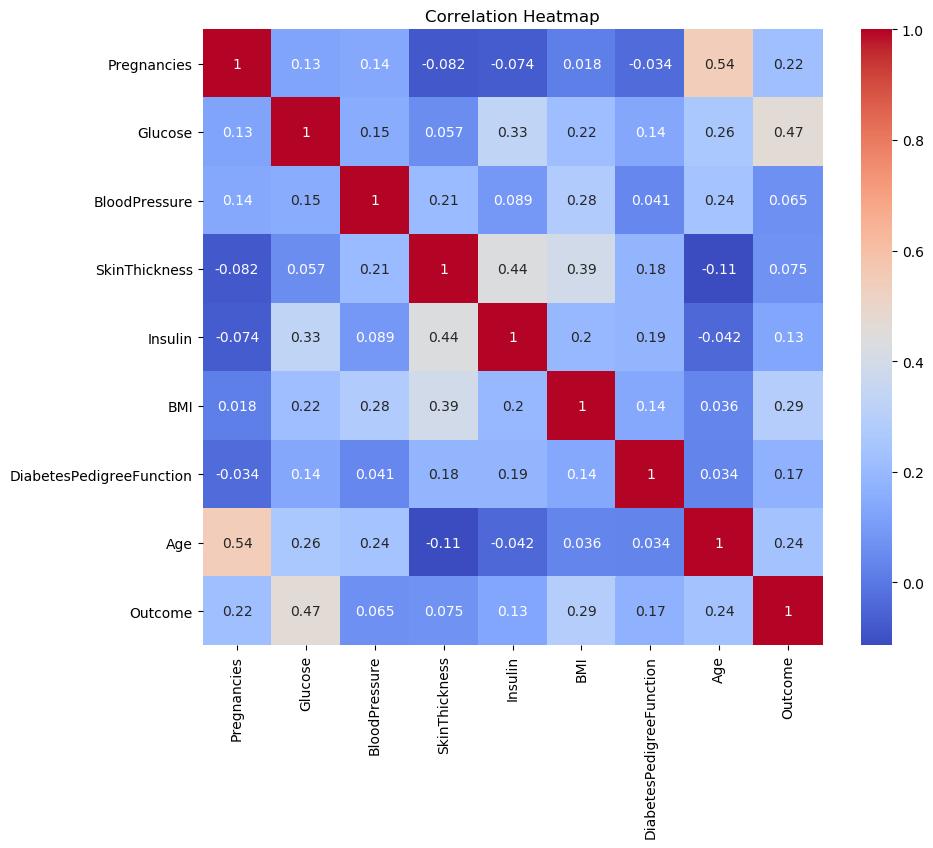

In [24]:
# Explore correlations between features
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

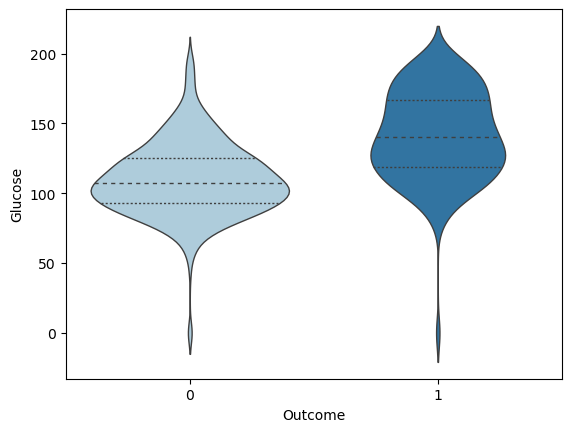

In [25]:
# Explore Gluecose vs Outcome
sns.violinplot(data=df, x="Outcome", y="Glucose",
               split=True, inner="quart", linewidth=1)
plt.show()

## Spit the data into training and testing set

In [29]:
# First define feature and target variables.
X = df.drop(['Outcome'], axis = 1)
y = df[['Outcome']]

In [30]:
# Split the data into 80% training and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [31]:
print(f'Shape of Training Data: {X_train.shape}, \nShape of Testing Data: {X_test.shape}')

Shape of Training Data: (614, 8), 
Shape of Testing Data: (154, 8)


## Scale the numeric Data

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Address Class Imbalance Usign SMOTE

In [35]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [36]:
y_train_resampled.value_counts()

Outcome
0          401
1          401
dtype: int64

In [37]:
# Create a DataFrame by combining the resampled features and target
resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
resampled_df['Outcome'] = y_train_resampled

In [38]:
resampled_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.516591,0.750524,0.564756,1.652015,0.437496,0.795825,0.529526,0.567932,1
1,1.812018,0.244752,-0.347904,1.020973,-0.678474,1.228654,-0.069689,0.398450,1
2,0.925736,-0.608739,0.260536,1.273390,0.222886,0.704013,-0.794249,0.991638,0
3,1.221164,-0.039745,0.463350,-1.250779,-0.678474,-0.896139,-0.167519,2.601722,0
4,-0.551400,-0.039745,0.361943,1.084077,0.222886,1.031914,-0.760619,-0.364222,0
...,...,...,...,...,...,...,...,...,...
797,1.228039,0.702751,-0.130931,-1.250779,-0.678474,0.395935,-1.022188,0.660562,1
798,0.444504,0.754102,0.628535,0.425054,1.514841,0.099851,0.100071,2.030386,1
799,-0.468133,0.614075,0.463350,1.119650,0.891143,1.152893,2.105242,-0.194739,1
800,1.551500,-0.653562,0.415865,1.046794,-0.678474,0.171022,0.672929,1.176514,1


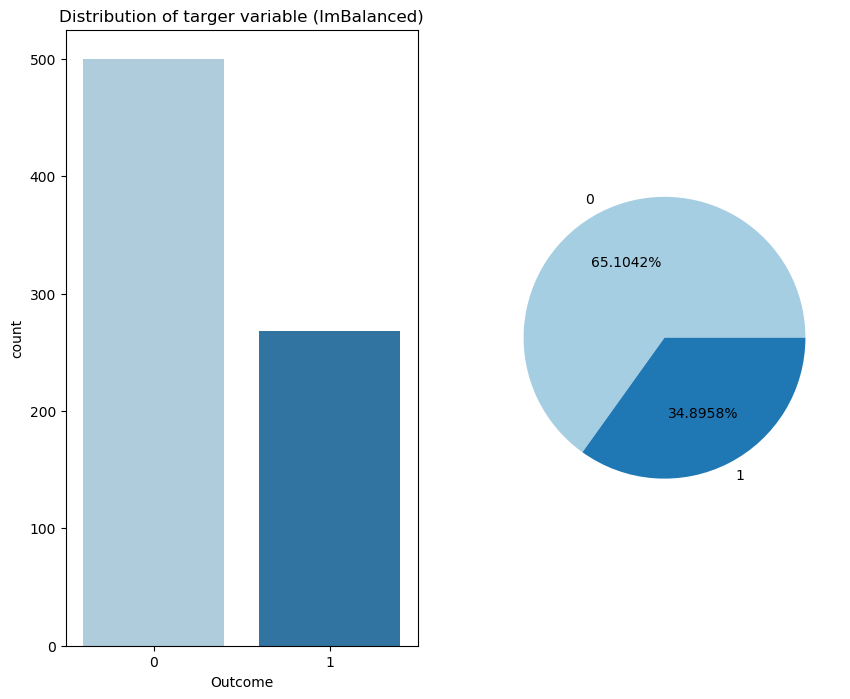

In [39]:
labels = ['0', '1']
values = df['Outcome'].value_counts().values


plt.figure(figsize = (10,8))

plt.subplot(1, 2, 1)
sns.countplot(x = df['Outcome'], data =df)
plt.title("Distribution of targer variable (ImBalanced)")
plt.subplot(1, 2, 2)
plt.pie(values, labels=labels, autopct='%1.4f%%')

plt.show()

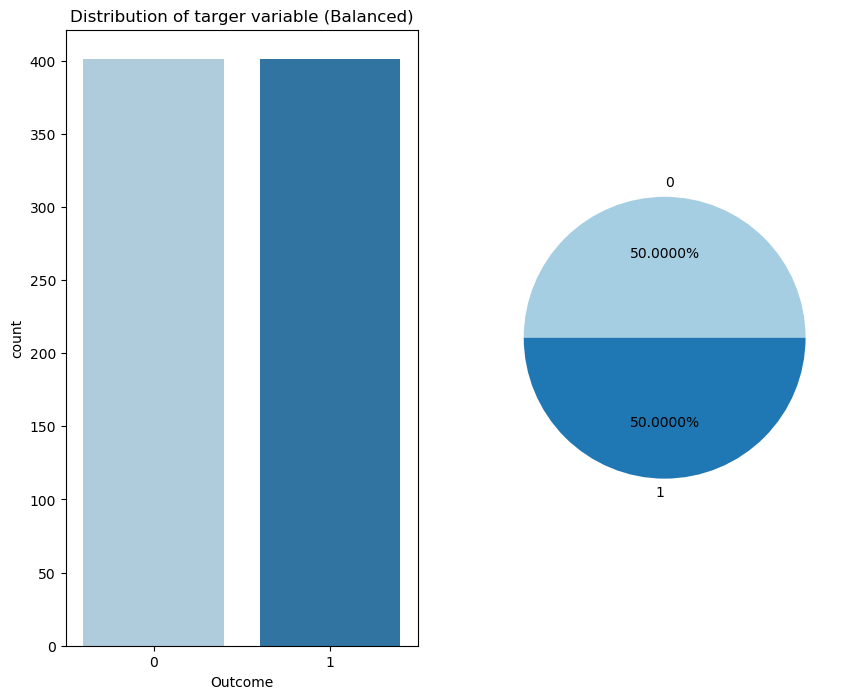

In [41]:
labels = ['0', '1']
values = resampled_df['Outcome'].value_counts().values

plt.figure(figsize = (10,8))
plt.subplot(1, 2, 1)
sns.countplot(x = resampled_df['Outcome'], data = resampled_df)
plt.title("Distribution of targer variable (Balanced)")
plt.subplot(1, 2, 2)
plt.pie(values, labels=labels, autopct='%1.4f%%')

plt.show()

## Train different ML models

In [42]:
# Define SageMaker role and session
role = get_execution_role()
sagemaker_session = sagemaker.Session()

# Define the parameter grid for each model (you can adjust these parameters)
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
param_grid_gb = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    
    # Reshape y_train and y_test
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    best_models = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Grid search for hyperparameter optimization
        if model_name == 'Logistic Regression':
            grid_search = GridSearchCV(model, param_grid_lr, cv=3, scoring='accuracy')
        elif model_name == 'Random Forest':
            grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='accuracy')
        elif model_name == 'Gradient Boosting':
            grid_search = GridSearchCV(model, param_grid_gb, cv=3, scoring='accuracy')

        # Train the best model
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model

        # Evaluate the model on test data
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        
        print(f"{model_name} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        
        with open(f"{model_name}.pkl", 'wb') as model_file:
            pickle.dump(best_model, model_file)
        
    return best_models


In [44]:
X_train_resampled.shape

(802, 8)

In [45]:
# Call the function with your X_train, y_train, X_test, and y_test
best_models = train_and_evaluate_models(X_train_resampled, y_train_resampled, X_test_scaled, y_test)

Training Logistic Regression...
Logistic Regression Accuracy: 0.7922, Precision: 0.7018, Recall: 0.7273, F1-Score: 0.7143, ROC-AUC: 0.7778
Training Random Forest...
Random Forest Accuracy: 0.7922, Precision: 0.6825, Recall: 0.7818, F1-Score: 0.7288, ROC-AUC: 0.7899
Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7597, Precision: 0.6286, Recall: 0.8000, F1-Score: 0.7040, ROC-AUC: 0.7687


In [4]:
default_bucket = sagemaker_session.default_bucket()

NameError: name 'sagemaker_session' is not defined

In [5]:
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print("Default S3 Bucket:", default_bucket)

Default S3 Bucket: sagemaker-us-east-1-250738637992


In [6]:
# Specify the S3 bucket name and pickle file name
s3_bucket =   default_bucket
pickle_file_name = 'Random Forest.pkl'

# Upload the pickle file to S3
s3_client = boto3.client('s3')
s3_client.upload_file(pickle_file_name, s3_bucket, pickle_file_name)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [8]:
cd .

/root
